In [3]:
# Our usual imports
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# This will add the .hvplot() function to your DataFrame!
# Import holoviews too
import holoviews as hv
import hvplot.pandas

hv.extension("bokeh")

In [5]:
import rasterio as rio

In [6]:
# Open the file and get a file "handle"
landsat = rio.open("https://raw.githubusercontent.com/MUSA-550-Fall-2023/week-5/main/data/landsat8_philly.tif")
landsat

<open DatasetReader name='https://raw.githubusercontent.com/MUSA-550-Fall-2023/week-5/main/data/landsat8_philly.tif' mode='r'>

In [7]:
data = landsat.read(1)

data

array([[10901, 10618, 10751, ..., 12145, 11540, 14954],
       [11602, 10718, 10546, ..., 11872, 11982, 12888],
       [10975, 10384, 10357, ..., 11544, 12318, 12456],
       ...,
       [12281, 12117, 12072, ..., 11412, 11724, 11088],
       [12747, 11866, 11587, ..., 11558, 12028, 10605],
       [11791, 11677, 10656, ..., 10615, 11557, 11137]], dtype=uint16)

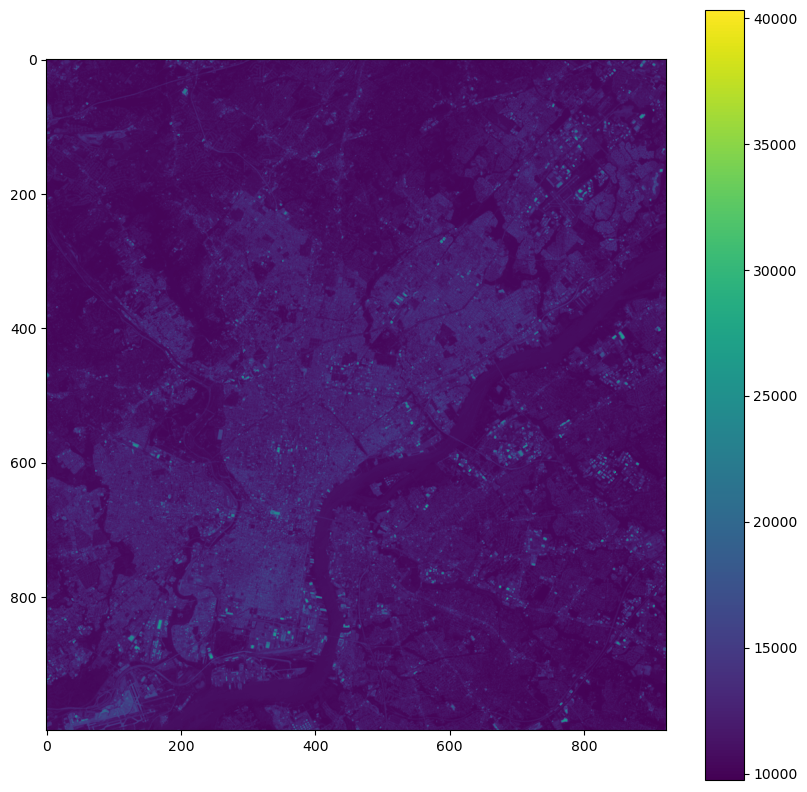

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

img = ax.imshow(data)

plt.colorbar(img)

In [7]:
import matplotlib.colors as mcolors

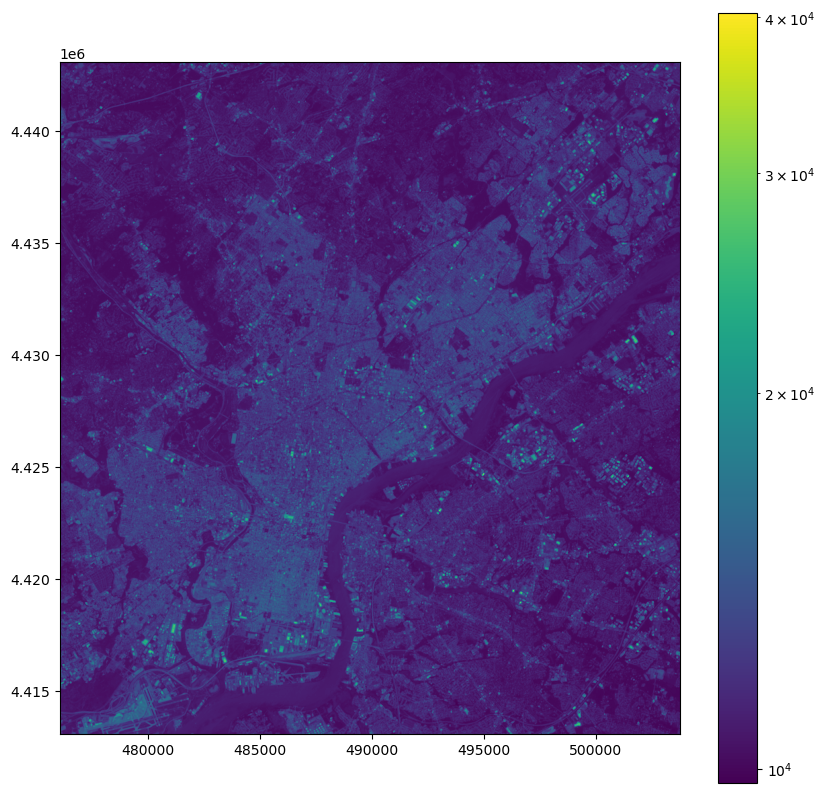

In [8]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
img = ax.imshow(
    data,
    # Use a log colorbar scale
    norm=mcolors.LogNorm(),
    # Set the extent of the images
    extent=[
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ],
)

# Add a colorbar
plt.colorbar(img);

In [9]:
city_limits = gpd.read_file("./data/City_Limits.geojson")

In [10]:
# Convert to the correct CRS!
print(landsat.crs.data)

{'init': 'epsg:32618'}


In [11]:
city_limits = city_limits.to_crs(landsat.crs.data["init"])

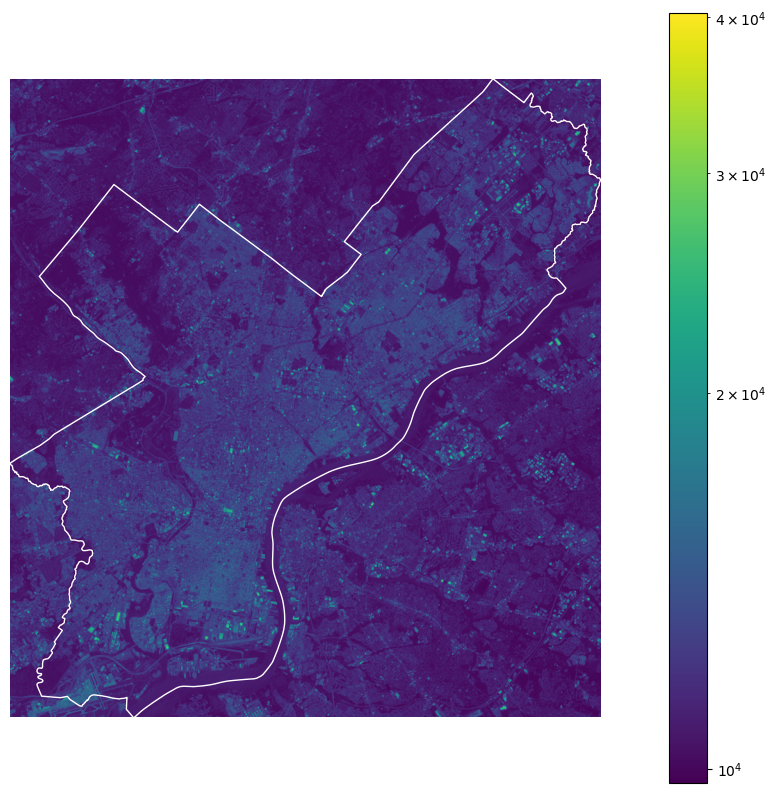

In [12]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# The extent of the data
landsat_extent = [
    landsat.bounds.left,
    landsat.bounds.right,
    landsat.bounds.bottom,
    landsat.bounds.top,
]

# Plot!
img = ax.imshow(data, norm=mcolors.LogNorm(), extent=landsat_extent)  # NEW  # NEW

# Add the Square limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white")

# Add a colorbar and turn off axis lines
plt.colorbar(img)
ax.set_axis_off()

In [13]:
from rasterio.mask import mask

In [14]:
landsat

<open DatasetReader name='./data/landsat8_philly.tif' mode='r'>

In [15]:
masked, mask_transform = mask(
    dataset=landsat,              # The original raster data
    shapes=city_limits.geometry,  # The vector geometry we want to crop by
    crop=True,                    # Optional: remove pixels not within boundary
    all_touched=True,             # Optional: get all pixels that touch the boudnary
    filled=False,                 # Optional: do not fill cropped pixels with a default value
)

In [16]:
masked.shape

(10, 999, 923)

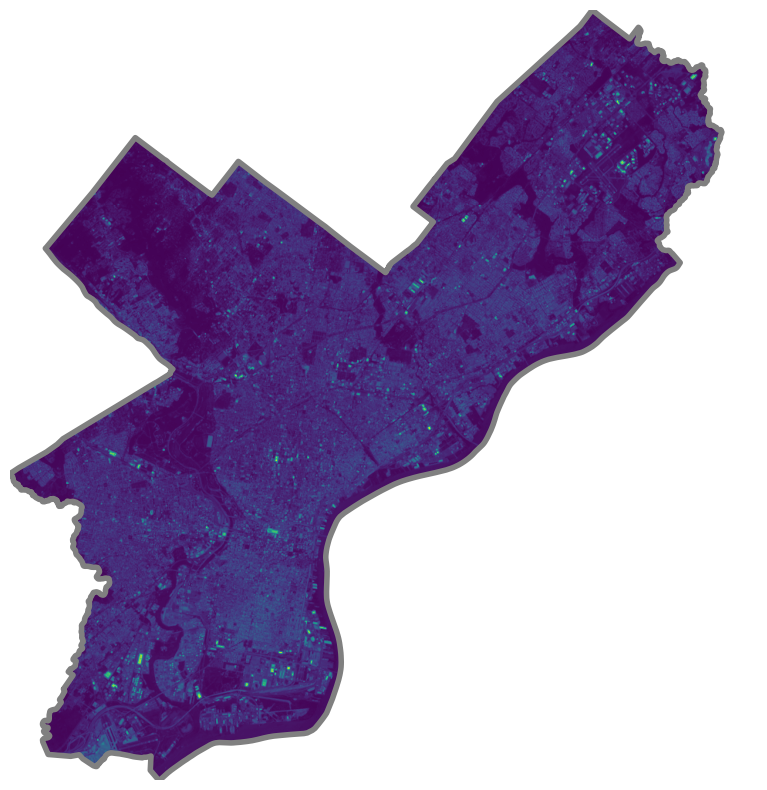

In [17]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first band
ax.imshow(masked[0], cmap="viridis", extent=landsat_extent)

# Format and add the city limits
city_limits.boundary.plot(ax=ax, color="gray", linewidth=4)
ax.set_axis_off()

In [18]:
# Note that the indexing here is zero-based, e.g., band 1 is index 0
red = masked[3]
nir = masked[4]

In [19]:
def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """

    # Convert to floats
    nir = nir.astype(float)
    red = red.astype(float)

    # Get valid entries
    check = np.logical_and(red.mask == False, nir.mask == False)

    # Where the check is True, return the NDVI, else return NaN
    ndvi = np.where(check, (nir - red) / (nir + red), np.nan)
    
    # Return
    return ndvi

In [20]:
NDVI = calculate_NDVI(nir, red)

Text(0.5, 1.0, 'NDVI in Philadelphia')

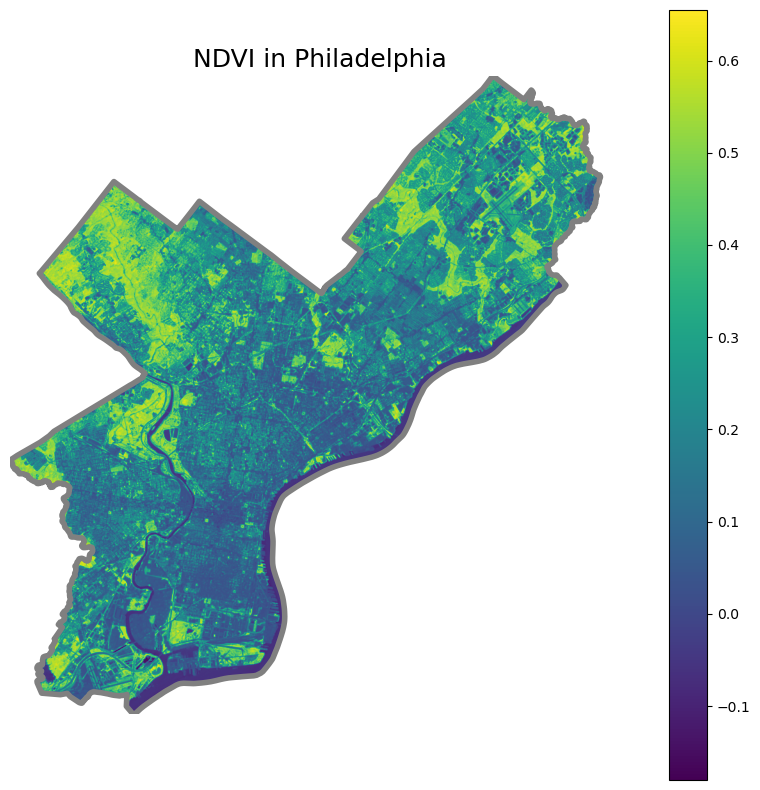

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot NDVI
img = ax.imshow(NDVI, extent=landsat_extent)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI in Philadelphia", fontsize=18)

In [22]:
# Read in the parks dataset
squares = gpd.read_file("./data/square.geojson")

In [23]:
# Print out the CRS
squares.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
landsat.crs

CRS.from_epsg(32618)

In [25]:
landsat.crs.data["init"]

'epsg:32618'

In [26]:
# Convert to landsat CRS
squares = squares.to_crs(landsat.crs.data["init"])

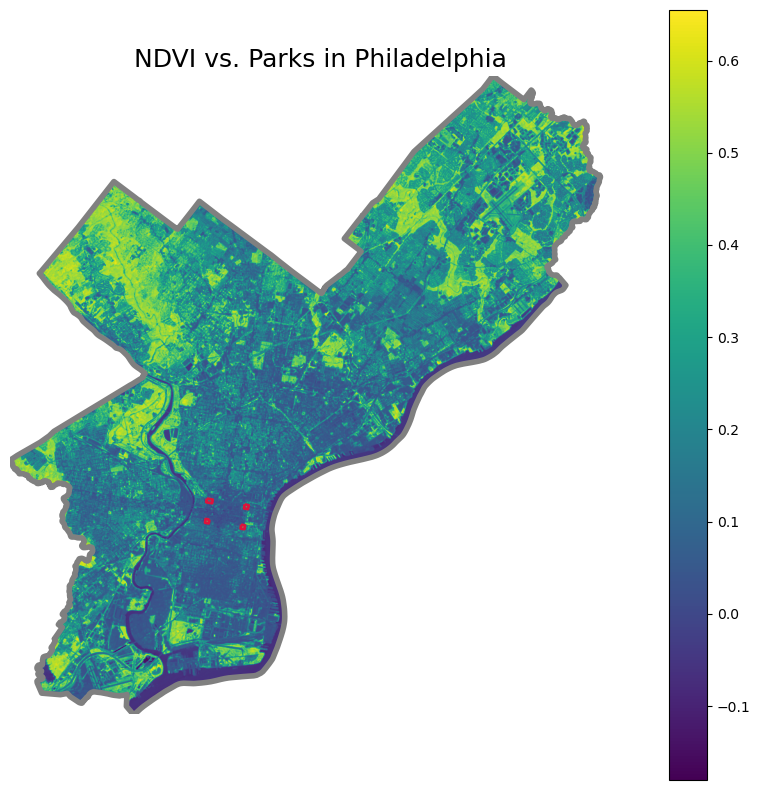

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot NDVI
img = ax.imshow(NDVI, extent=landsat_extent)

# Add the city limits
city_limits.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=4)

# NEW: add the parks
squares.plot(ax=ax, edgecolor="crimson", facecolor="none", linewidth=2)

# Format and add colorbar
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI vs. Parks in Philadelphia", fontsize=18);

In [28]:
from rasterstats import zonal_stats

In [29]:
stats = zonal_stats(
    squares,  # The vector data
    NDVI,  # The array holding the raster data
    affine=landsat.transform,  # The affine transform for the raster data
    stats=["mean", "median"],  # The stats to compute
    nodata=np.nan,  # Missing data representation
)

In [30]:
median_stats = [s["median"] for s in stats]

In [31]:
squares["median_NDVI"] = median_stats

In [32]:
squares.head()

OBJECTID  Shape_Length    Shape_Area                Name  \
0         1    988.563775  60976.353043     Franklin Square   
1         2    950.355597  56422.312587   Washington Square   
2         3   1180.863654  82846.668242        Logan Square   
3         4    928.959151  53917.150666  Rittenhouse Square   

                                            geometry  median_NDVI  
0  POLYGON ((487077.010 4422949.922, 487046.563 4...     0.302782  
1  POLYGON ((486912.866 4421997.104, 486885.592 4...     0.418753  
2  POLYGON ((485305.809 4423224.747, 485275.346 4...     0.193237  
3  POLYGON ((485418.065 4422235.931, 485243.707 4...     0.452164

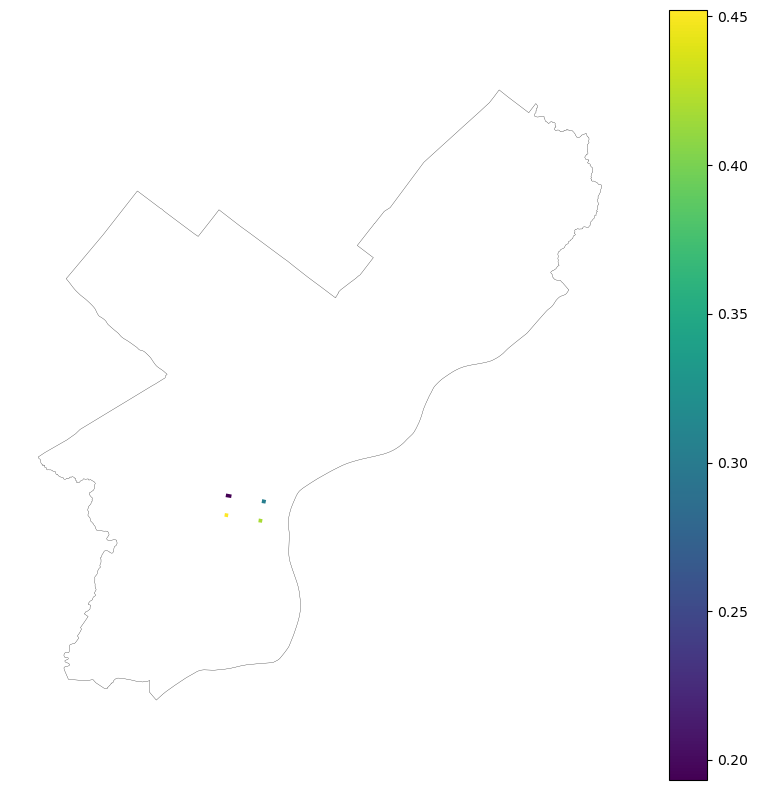

In [37]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the city limits
city_limits.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.2)

# Plot the median NDVI
squares.plot(column="median_NDVI", legend=True, ax=ax, cmap="viridis")

# Format
ax.set_axis_off()

In [35]:
# trim to only the columns we want to plot
cols = ["median_NDVI", "Name", "geometry"]

# Plot the parks colored by median NDVI
p = squares[cols].hvplot.polygons(
    c="median_NDVI", geo=True, crs=32618, cmap="viridis", hover_cols=["Name"]
)

# Plot the city limit boundary
cl = city_limits.hvplot.polygons(
    geo=True,
    crs=32618,
    alpha=0,
    line_alpha=1,
    line_color="black",
    hover=False,
    width=700,
    height=600,
)

# combine!
cl * p

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]   (median_NDVI,Name)